# Linear model (Titanic) (2025-04-02,08)
contents: [dataset-> Titanic]

from scratch:
- project 1: Simple linear model use pytorch (gradient descent)
- project 2: Linear model use Neural Network
- project 3: with Deep learning (>1 hidden layers)

use a framework:
- project 4: using the Fastai framework

# Simple linear model
## Setting & download Titanic
- tabular data: csv
- linear model using neural network [from scratch version]& [use a framework]
- target: predict whether a new person is survived or not

In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=80)
torch.set_printoptions(linewidth=120, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 80)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Clean data, feature engineering
- check missing values?
- fillna
- Fare -> LogFare
- get dummy values
- transform to tensors (label, features)

In [40]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [42]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
modes = df.mode().iloc[0]

In [5]:
df.fillna(modes, inplace=True)

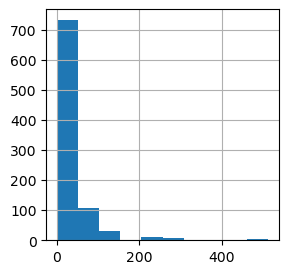

In [45]:
df['Fare'].hist(figsize=(3,3));

‘Fare' is longtail -> try log1p()

- 为什么长尾分布要取对数
    
    **1. 压缩尺度，缓解极端值影响**
    
    长尾分布（如点击率、城市人口）的数值范围跨度极大（如1~1e6）。取对数可将指数级差异转化为线性差异（log(1e6)≈14），使得模型能更均衡地学习不同区间的样本特征。这在你的扩散模型训练中尤为重要——防止少数高激活样本主导梯度更新。
    
    **2. 近似正态化分布**
    
    许多算法（如线性回归、GAN/Diffusion中的损失计算）假设数据服从高斯分布，取log后长尾数据更接近正态分布。


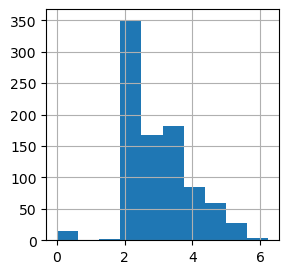

In [46]:
np.log1p(df['Fare']).hist(figsize=(3,3));

In [47]:
df['LogFare'] = np.log1p(df['Fare'])

In [48]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [49]:
df['Pclass'].unique()

array([3, 1, 2])

In [50]:
df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [52]:
df_dummy = pd.get_dummies(df, columns=['Sex','Pclass','Embarked'], dtype=float)
df_dummy.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [53]:
df_dummy.head(1)

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.25,B96 B98,2.110213,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
d_cols = ['Sex_female',	'Sex_male',	'Pclass_1',	'Pclass_2',	'Pclass_3',	'Embarked_C', 'Embarked_Q',	'Embarked_S']
df_dummy[d_cols].head(1)

In [60]:
from torch import tensor
t_label = tensor(df_dummy['Survived'])

In [57]:
features = ['Age', 'SibSp', 'Parch', 'LogFare']+ d_cols
df_dummy[features].head(1)

,Age,SibSp,Parch,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,2.110213,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [59]:
t_features = tensor(df_dummy[features].values, dtype=torch.float)
t_features[0]

tensor([22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  1.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  1.0000])

In [61]:
t_label[0]

tensor(0)

## Build a simple linear model

In [65]:
t_features.shape

torch.Size([891, 12])

random weights

In [292]:
torch.manual_seed(42)
n = t_features.shape[1]
w = torch.rand(n)-0.5
w[:10]

tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009, -0.2434,  0.2936,  0.4408, -0.3668])

**normalize all features**
- by divided by the maxmium value (dim=0)

In [ ]:
v, i = t_features.max(dim=0)

t_features = t_features/v

In [82]:
t_features*w

tensor([[ 0.1051,  0.0519, -0.0000,  0.1553, -0.0000,  0.1009, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [ 0.1816,  0.0519, -0.0000,  0.3150, -0.1096,  0.0000, -0.2434,  0.0000,  0.0000, -0.3668,  0.0000,  0.0000],
        [ 0.1242,  0.0000, -0.0000,  0.1611, -0.1096,  0.0000, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [ 0.1672,  0.0519, -0.0000,  0.2937, -0.1096,  0.0000, -0.2434,  0.0000,  0.0000, -0.0000,  0.0000,  0.0936],
        [ 0.1672,  0.0000, -0.0000,  0.1621, -0.0000,  0.1009, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [ 0.1147,  0.0000, -0.0000,  0.1654, -0.0000,  0.1009, -0.0000,  0.0000,  0.4408, -0.0000,  0.4346,  0.0000],
        [ 0.2580,  0.0000, -0.0000,  0.2920, -0.0000,  0.1009, -0.2434,  0.0000,  0.0000, -0.0000,  0.0000,  0.0936],
        ...,
        [ 0.1195,  0.0000, -0.0000,  0.1535, -0.0000,  0.1009, -0.0000,  0.0000,  0.4408, -0.0000,  0.0000,  0.0936],
        [ 0.1864,  0.0000, -0.0976,  0.2506

In [84]:
preds = (t_features*w).sum(dim=1)

In [87]:
loss = torch.abs(preds - t_label).mean()
loss

tensor(0.7042)

**Make them into functions**

In [241]:
def cal_pred(features, weights): return (features*weights).sum(dim=1)
def cal_loss(features, weights, labels): return torch.abs(cal_pred(features,weights)-labels).mean()

## A step of gradient descent

In [97]:
loss #first

tensor(0.7042, grad_fn=<MeanBackward0>)

In [90]:
w.requires_grad_() 

tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009, -0.2434,  0.2936,  0.4408, -0.3668,  0.4346,  0.0936],
       requires_grad=True)

In [96]:
loss = cal_loss(t_features, w, t_label)
loss.backward()
with torch.no_grad():
    w.sub_(0.1 * w.grad)
    w.grad.zero_
    print(cal_loss(t_features, w, t_label))

tensor(0.5944)


## Train the linear model
- split the data -> RandomSplitter
- put the process into functions

In [98]:
from fastai.data.transforms import RandomSplitter

In [ ]:
RandomSplitter??

In [250]:
trn_idx, val_idx = RandomSplitter(seed=42)(df_dummy)
trn_f, val_f = t_features[trn_idx], t_features[val_idx]
trn_y, val_y = t_label[trn_idx], t_label[val_idx]
len(trn_y), len(val_y)

(713, 178)

In [159]:
def update_w(w, lr):
    w.sub_(w.grad * lr)
    w.grad.zero_()

In [266]:
def one_epoch(w, lr):
    loss = cal_loss(trn_f, w, trn_y)
    loss.backward()
    with torch.no_grad(): update_w(w, lr)
    print(f"{loss:.3f}",end= ";")

In [161]:
def init_w(): return (torch.rand(n)-0.5).requires_grad_()

In [162]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(25)
    w = init_w()
    for i in range(epochs): one_epoch(w, lr=lr)
    return w

In [163]:
n

12

In [175]:
w = train_model(10, 0.2)

0.641;0.407;0.397;0.370;0.358;0.354;0.354;0.327;0.324;0.330;

In [176]:
def show_weights(): return dict(zip(features, w.requires_grad_(False)))

In [177]:
show_weights()

{'Age': tensor(0.3120),
 'SibSp': tensor(-0.2559),
 'Parch': tensor(-0.3784),
 'LogFare': tensor(0.6073),
 'Sex_female': tensor(0.2598),
 'Sex_male': tensor(-0.1948),
 'Pclass_1': tensor(0.1746),
 'Pclass_2': tensor(-0.1006),
 'Pclass_3': tensor(-0.0648),
 'Embarked_C': tensor(0.0891),
 'Embarked_Q': tensor(-0.3094),
 'Embarked_S': tensor(0.0595)}

## Accuracy (predictions)

In [178]:
preds = cal_pred(val_f, w)

In [179]:
results = val_y.bool() == (preds>0.5)
results[:5]

tensor([False,  True,  True,  True,  True])

In [180]:
results.float().mean()

tensor(0.7416)

In [181]:
def acc(w): return (val_y.bool() == (cal_pred(val_f,w)>0.5)).float().mean()

In [182]:
acc(w)

tensor(0.7416)

## Predictions - Sigmoid

In [183]:
preds[:20]

tensor([ 0.1955, -0.2645,  0.1281,  0.2537,  0.1183,  0.1654,  0.4962,  0.5846, -0.1058,  0.5892,  0.1376,  0.0993,
        -0.0367,  0.1917,  0.1285,  0.5375,  0.6155,  0.5738,  0.2368,  0.5963])

some predictions <0 but we need label 'Survived' between 0~1

In [196]:
#revise the cal_pred function:
def cal_pred(features, w): return torch.sigmoid((features*w).sum(dim=1))

In [199]:
w = train_model(lr=50)

0.464;0.311;0.232;0.211;0.209;0.208;0.206;0.205;0.204;0.203;0.203;0.202;0.202;0.201;0.201;0.200;0.200;0.200;0.199;0.199;0.199;0.199;0.199;0.198;0.198;0.198;0.198;0.198;0.198;0.197;

In [201]:
acc(w)

tensor(0.8258)

In [202]:
show_weights()

{'Age': tensor(-0.4818),
 'SibSp': tensor(-1.4803),
 'Parch': tensor(-1.2493),
 'LogFare': tensor(0.7345),
 'Sex_female': tensor(5.7221),
 'Sex_male': tensor(-6.2158),
 'Pclass_1': tensor(1.8344),
 'Pclass_2': tensor(1.9067),
 'Pclass_3': tensor(-4.2905),
 'Embarked_C': tensor(0.9280),
 'Embarked_Q': tensor(1.4801),
 'Embarked_S': tensor(-3.1275)}

## Deal with Test set

In [225]:
test_df = pd.read_csv(path/'test.csv')

test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [226]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [ ]:
#fare has only one missing value, fillna with 0
test_df['Fare'] = test_df.Fare.fillna(0)

#fillna with modes
test_df.fillna(modes, inplace=True)

#log fare
test_df['LogFare'] = np.log1p(test_df['Fare'])

#get dummy features
test_df = pd.get_dummies(test_df, columns=['Sex','Pclass','Embarked'],dtype=float)

In [231]:
test_df.head(1)

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,B96 B98,2.178064,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [236]:
test_f = tensor(test_df[features].values, dtype=float)
test_f = test_f/v

In [237]:
test_df['Survived'] = (cal_pred(test_f, w)>0.5).int()

according to kaggle competition of Titanic, its submission should like this form:

In [238]:
submission_df = test_df[['PassengerId','Survived']]
submission_df.to_csv('sub.csv', index=False)

In [239]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


## Instead: if Use matrix product

In [243]:
def cal_pred(x,w): return torch.sigmoid(x@w)

In [244]:
def init_w(): return (torch.rand(n,1)*0.1).requires_grad_()

In [251]:
trn_y = trn_y[:,None]
val_y = val_y[:,None]

In [252]:
ww = train_model(lr=100)

0.508;0.323;0.295;0.206;0.200;0.198;0.197;0.197;0.196;0.196;0.196;0.195;0.195;0.195;0.195;0.195;0.195;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.194;0.194;

In [253]:
acc(ww)

tensor(0.8258)

# Linear model use NN (1 hidden layer)

In [254]:
import torch.nn.functional as F

In [255]:
def init_w(hidden=20):
    layer1 = (torch.rand(n, hidden)-0.5)/hidden
    layer2 = torch.rand(hidden,1) - 0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [256]:
def cal_pred(x,w):
    l1, l2, const = w
    res = F.relu(x@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [270]:
def update_w(w, lr):
    for l in w:
        l.sub_(l.grad * lr)
        l.grad.zero_()

In [271]:
w = train_model(lr=1.4)

0.534;0.524;0.510;0.490;0.467;0.440;0.410;0.377;0.347;0.322;0.302;0.287;0.274;0.264;0.256;0.249;0.244;0.239;0.236;0.233;0.230;0.228;0.227;0.225;0.224;0.222;0.221;0.220;0.219;0.218;

In [272]:
w = train_model(lr=10)

0.534;0.469;0.344;0.261;0.231;0.214;0.209;0.206;0.204;0.202;0.201;0.199;0.198;0.198;0.197;0.197;0.196;0.196;0.196;0.195;0.195;0.195;0.195;0.195;0.195;0.194;0.194;0.194;0.194;0.194;

In [273]:
acc(w)

tensor(0.8258)

# Linear model use Deep Learning (hidden layers)

In [329]:
n

12

In [ ]:
def init_w():
    hidden = [10,10]
    sizes = [n] + hidden + [1]
    k = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.5)/sizes[i+1]*4 for i in range(k-1)]
    const = [(torch.rand(1)[0] - 0.3)*0.1 for i in range(k-1)]
    for l in layers+const: l.requires_grad_()
    return layers, const

def cal_pred(x,w):
    layers, const = w
    k = len(layers)
    res = x
    for i, l in enumerate(layers):
        res = res@l + const[i]
        if i!=k-1: res = F.relu(res)
    return torch.sigmoid(res)

def update_w(w, lr):
    layers, const = w
    for l in layers+const:
        l.sub_(l.grad * lr)
        l.grad.zero_()

In [368]:
w = train_model(lr=1.4)

0.520;0.498;0.493;0.488;0.483;0.478;0.473;0.469;0.464;0.460;0.456;0.452;0.448;0.445;0.442;0.439;0.436;0.433;0.431;0.429;0.426;0.424;0.423;0.421;0.419;0.418;0.416;0.415;0.413;0.412;

In [369]:
w = train_model(lr=10)

0.520;0.468;0.439;0.421;0.410;0.403;0.399;0.396;0.393;0.392;0.390;0.389;0.388;0.387;0.387;0.386;0.386;0.385;0.385;0.384;0.384;0.384;0.384;0.383;0.383;0.383;0.383;0.383;0.382;0.382;

In [370]:
acc(w)

tensor(0.5955)

# Use fastai framework

good EDA tutorial and advanced feature engineering: https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/ 

- score(0.81578)

In [6]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [615]:
df = pd.read_csv(path/'train.csv')
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C


In [7]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [577]:
df.Embarked.fillna("S",inplace=True)

/var/folders/xj/8l_ygs2j78j5kdmlxmyjm_nc0000gn/T/ipykernel_25862/666562755.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.Embarked.fillna("S",inplace=True)


In [571]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,None


In [579]:
df["Age"].median()

28.0

In [580]:
df["Age"] = df["Age"].fillna(df["Age"].median())

## feature engineering

In [8]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

## dls

In [9]:
splits = RandomSplitter(seed=42)(df)

In [10]:
dls = TabularPandas(df, splits=splits,
                   procs=[Categorify, FillMissing, Normalize],
                   cat_names=["Sex", "Pclass","Deck","Embarked"],
                   cont_names=["LogFare", "TicketFreq", "Age", "Family", "SibSp", "Parch", "Alone"],
                   y_names="Survived",
                   y_block=CategoryBlock()).dataloaders(path=".")

## train

In [11]:
learn= tabular_learner(dls, metrics=accuracy, layers=[12,12])

SuggestedLRs(slide=0.04786301031708717, valley=0.015848932787775993)

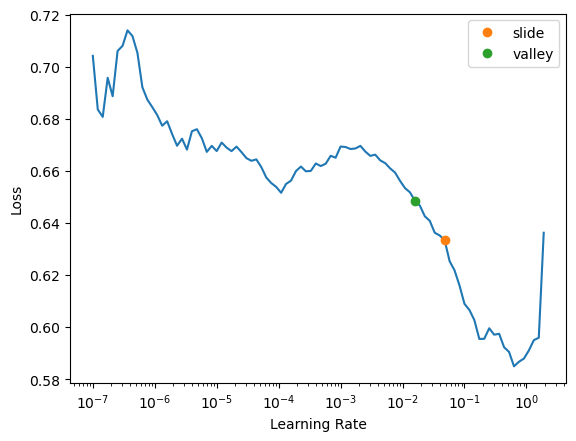

In [12]:
learn.lr_find(suggest_funcs=(slide, valley))

In [14]:
learn.fit(20, lr=0.08)

epoch,train_loss,valid_loss,accuracy,time
0,0.425138,0.465505,0.803371,00:00
1,0.414463,0.470233,0.803371,00:00
2,0.421603,0.486132,0.814607,00:00
3,0.427907,0.462166,0.780899,00:00
4,0.427933,0.470307,0.820225,00:00
5,0.431889,0.402623,0.825843,00:00
6,0.418748,0.483935,0.820225,00:00
7,0.427590,0.450646,0.797753,00:00
8,0.425676,0.474934,0.775281,00:00
9,0.425416,0.499103,0.820225,00:00


## Deal with test df in Learner

In [15]:
tst_df = pd.read_csv(path/'test.csv')

In [16]:
tst_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [17]:
tst_df.fillna(modes, inplace=True)

In [18]:
add_features(tst_df)

In [19]:
tst_df.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,Deck,Family,Alone,TicketFreq,Title
179,1071,1,"Compton, Mrs. Alexander Taylor (Mary Eliza Ingersoll)",female,64.00,0,2,PC 17756,83.16,E45,C,4.43,DE,2,False,2,Mrs
193,1085,2,"Lingane, Mr. John",male,61.00,0,0,235509,12.35,B96 B98,Q,2.59,ABC,0,False,1,Mr
203,1095,2,"Quick, Miss. Winifred Vera",female,8.00,1,1,26360,26.00,B96 B98,S,3.30,ABC,2,False,1,Miss


In [20]:
tst_dl = learn.dls.test_dl(tst_df)

In [424]:
#preds, _ = learn.get_preds(dl=tst_dl)

In [425]:
#tst_df['Survived']=(preds[:,1]>0.5).int

## Ensemble

In [21]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[12,12])
    with learn.no_bar(), learn.no_logging(): learn.fit(20, lr=0.08)
    return learn.get_preds(dl=tst_dl)[0]

In [22]:
learns = [ensemble() for _ in range(20)]

In [23]:
ens_preds = torch.stack(learns).mean(0)

## Submit

In [24]:
tst_df['Survived']=(ens_preds[:,1]>0.5).int()

In [25]:
submission=tst_df[['PassengerId', 'Survived']]

In [26]:
submission.to_csv('env_sub2.csv', index=False)

In [27]:
!head env_sub2.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


### score:0.76076

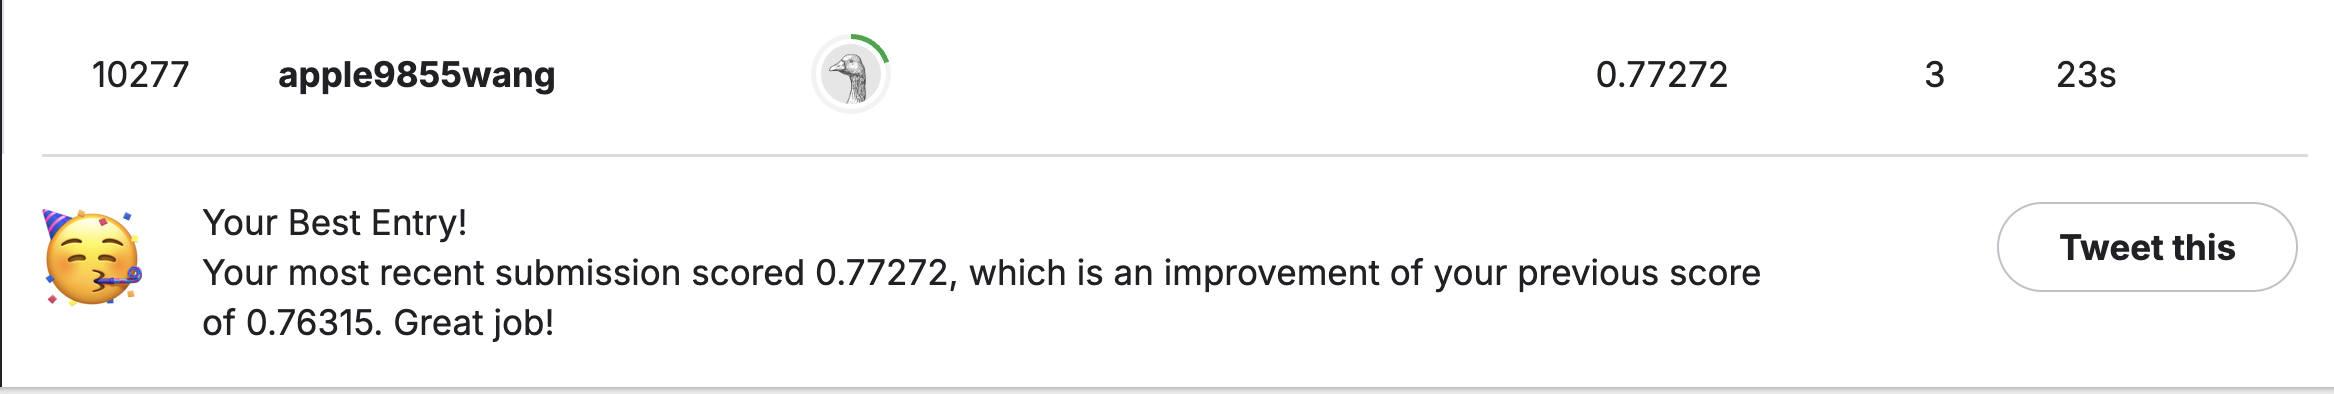
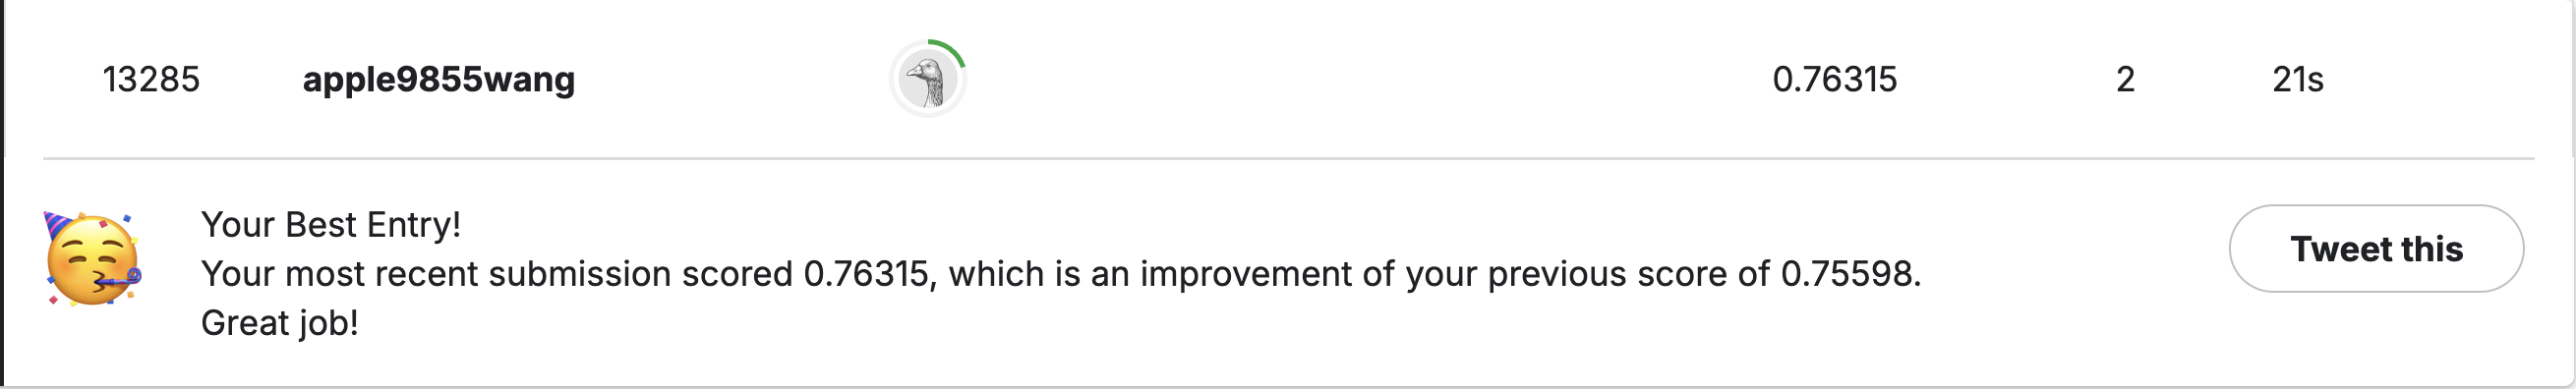

submit this output directly:
https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/


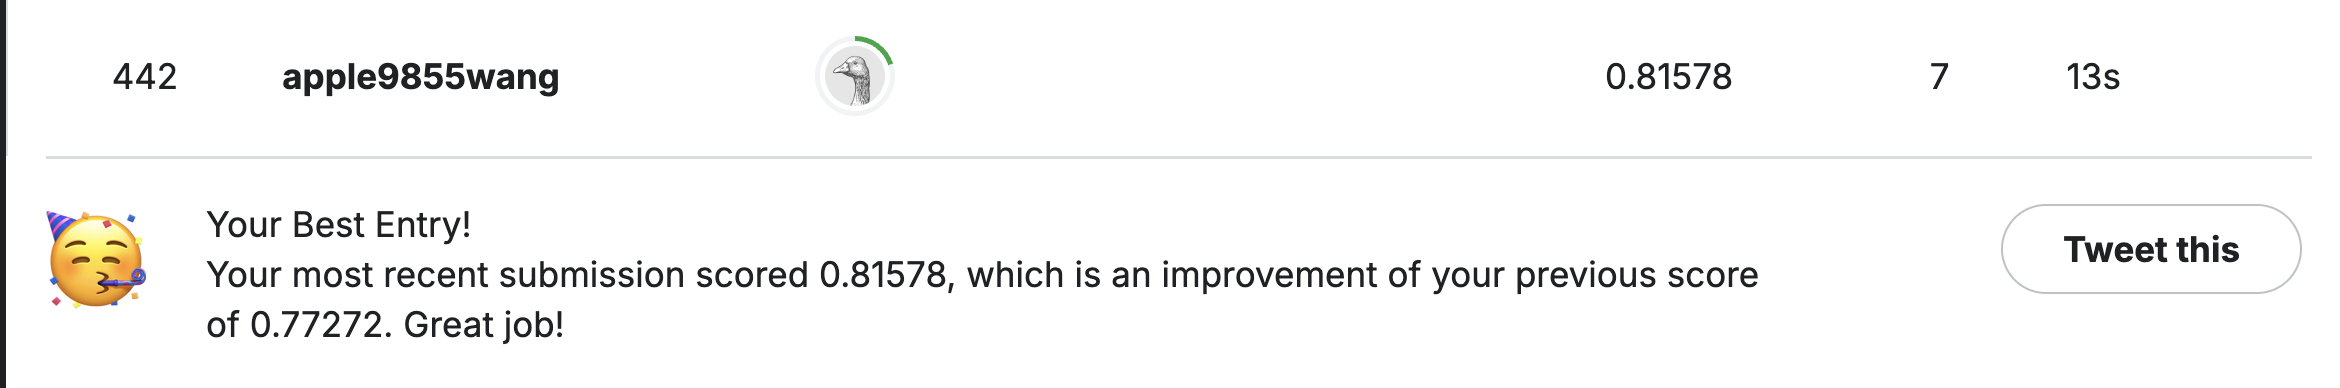